In [5]:
import numpy as np
import pandas as pd
import data_clean_utils
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer, MissingIndicator
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, MinMaxScaler, PowerTransformer, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import missingno as msno
import warnings
warnings.filterwarnings('ignore')
from sklearn import set_config
set_config(transform_output="pandas")   # it ensures that transformers return pandas DataFrames instead of NumPy arrays when transforming data.


In [6]:

# load the data
data=pd.read_csv(r'D:\Campus X\projects\swiggy-delivery-time-prediction\data\raw\swiggy.csv')
# clean the data
data_clean_utils.perform_data_cleaning(data)

In [7]:
# laod cleaned data
cleaned_data=pd.read_csv('swiggy_cleaned.csv')

In [8]:
cleaned_data.columns
# delete unwanted columns
columns_to_drop =  ['rider_id',
                    'restaurant_latitude',
                    'restaurant_longitude',
                    'delivery_latitude',
                    'delivery_longitude',
                    'order_date',
                    "order_time_hour",
                    "order_day"]
cleaned_data.drop(columns=columns_to_drop,inplace=True)
cleaned_data.sample(10)

,age,ratings,weather,traffic,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city_type,time_taken,city_name,order_month,order_day_of_week,is_weekend,pickup_time_minutes,order_time_of_day,distance,distance_type
16022,22.0,4.9,stormy,medium,0,drinks,motorcycle,1.0,no,metropolitian,25,MYS,3,sunday,1,15.0,evening,12.434913,long
36614,30.0,4.1,sandstorms,low,0,drinks,motorcycle,1.0,no,metropolitian,28,VAD,3,sunday,1,15.0,morning,NaN,NaN
26138,35.0,4.5,sandstorms,low,1,buffet,motorcycle,0.0,no,metropolitian,20,GOA,2,monday,0,5.0,night,10.808377,long
30499,37.0,4.7,sunny,low,0,snack,motorcycle,1.0,no,metropolitian,23,MUM,3,thursday,0,15.0,morning,3.059933,short
25516,25.0,4.5,sandstorms,low,0,drinks,motorcycle,0.0,no,metropolitian,17,INDO,3,monday,0,5.0,night,12.100062,long
28150,36.0,4.9,sunny,low,2,snack,electric_scooter,1.0,no,metropolitian,19,AGR,2,thursday,0,5.0,morning,NaN,NaN
34484,30.0,4.1,windy,low,0,drinks,motorcycle,1.0,no,metropolitian,34,SUR,3,tuesday,0,10.0,morning,3.040698,short
29446,NaN,NaN,stormy,medium,1,meal,scooter,1.0,no,metropolitian,21,JAP,3,wednesday,0,NaN,NaN,7.448304,medium
43882,32.0,4.4,stormy,jam,2,buffet,electric_scooter,2.0,no,metropolitian,42,JAP,3,wednesday,0,15.0,evening,11.917129,long
40081,37.0,4.3,fog,jam,1,buffet,scooter,1.0,no,metropolitian,35,PUNE,3,saturday,1,15.0,night,7.660520,medium


In [9]:
print(cleaned_data.info())
print('*'*50)
print(cleaned_data.isnull().sum())
print('*'*50)
print(cleaned_data.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45502 entries, 0 to 45501
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  43648 non-null  float64
 1   ratings              43594 non-null  float64
 2   weather              44977 non-null  object 
 3   traffic              44992 non-null  object 
 4   vehicle_condition    45502 non-null  int64  
 5   type_of_order        45502 non-null  object 
 6   type_of_vehicle      45502 non-null  object 
 7   multiple_deliveries  44509 non-null  float64
 8   festival             45274 non-null  object 
 9   city_type            44304 non-null  object 
 10  time_taken           45502 non-null  int64  
 11  city_name            45502 non-null  object 
 12  order_month          45502 non-null  int64  
 13  order_day_of_week    45502 non-null  object 
 14  is_weekend           45502 non-null  int64  
 15  pickup_time_minutes  43862 non-null 

<Axes: >

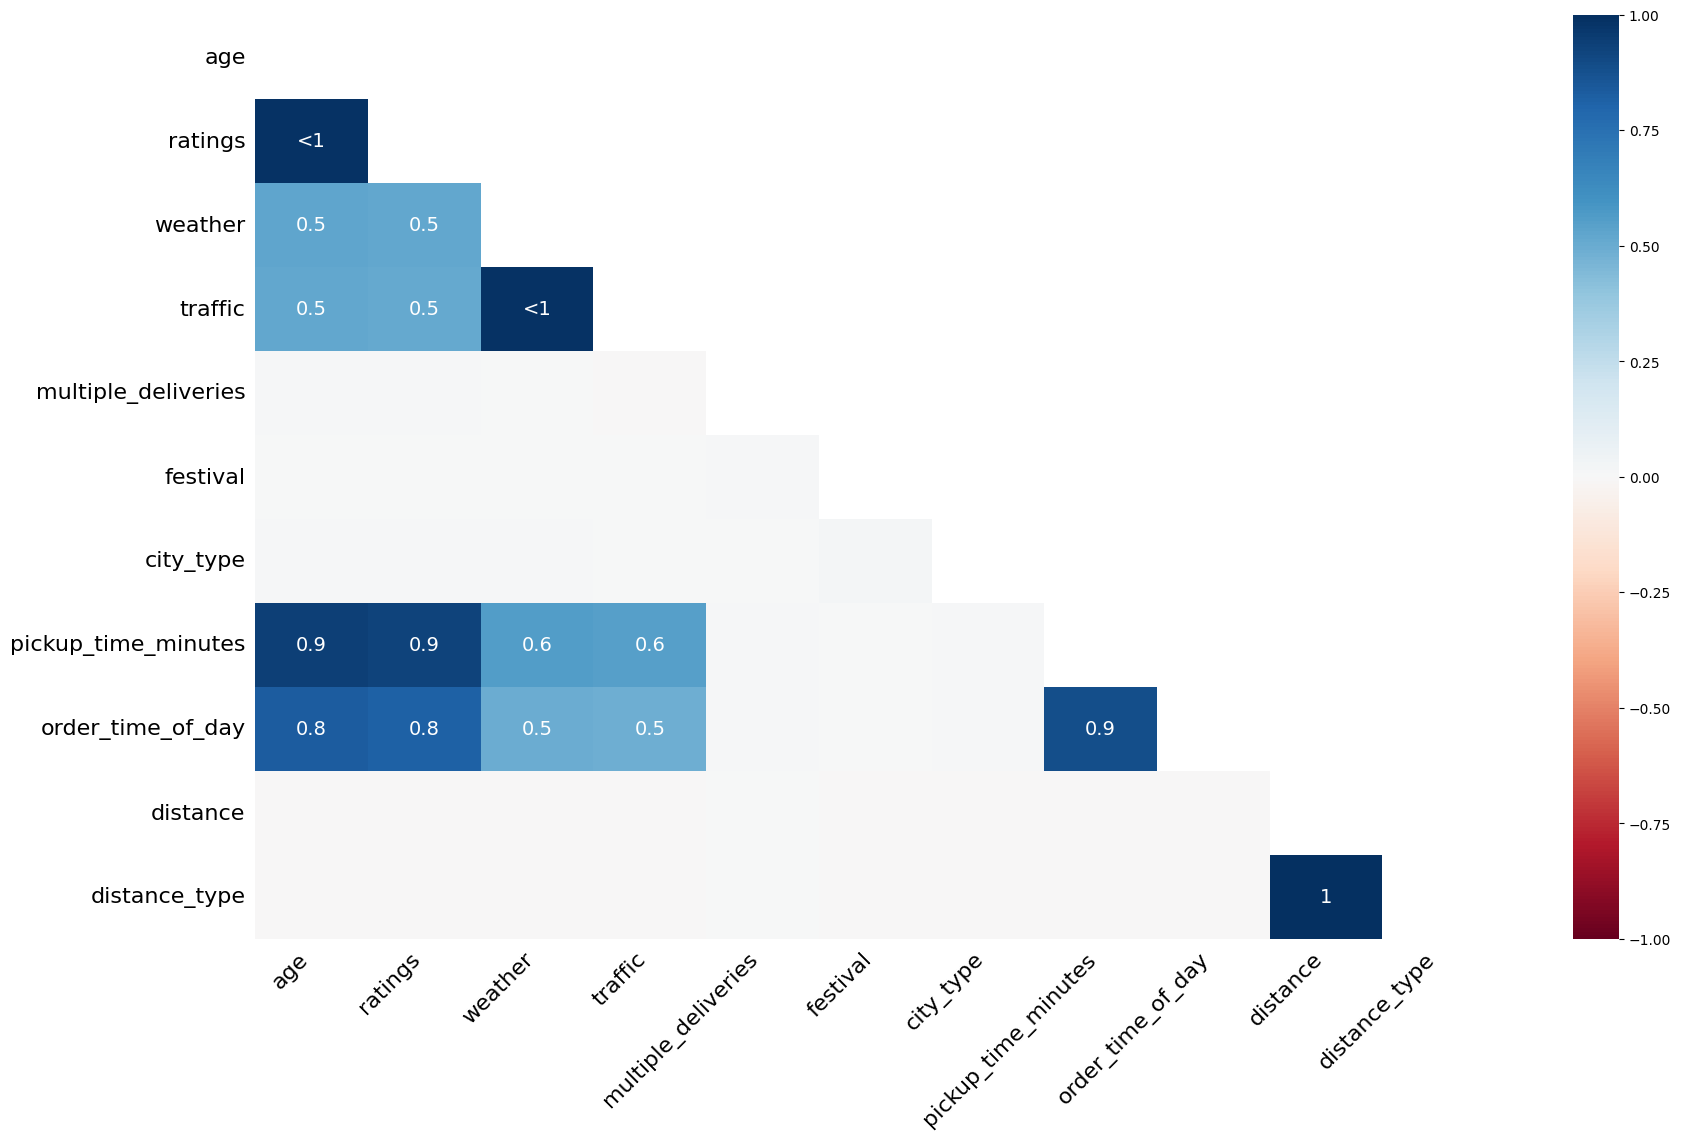

In [10]:

msno.heatmap(cleaned_data)

In [11]:
(
    cleaned_data.isna()
    .any()
    .loc[lambda x:x]
    .index
     
)

Index(['age', 'ratings', 'weather', 'traffic', 'multiple_deliveries',
       'festival', 'city_type', 'pickup_time_minutes', 'order_time_of_day',
       'distance', 'distance_type'],
      dtype='object')

# data preparation

In [12]:
# droping missing values
temp_df=cleaned_data.copy().dropna()
# split the data into X and y
temp_df.columns


Index(['age', 'ratings', 'weather', 'traffic', 'vehicle_condition',
       'type_of_order', 'type_of_vehicle', 'multiple_deliveries', 'festival',
       'city_type', 'time_taken', 'city_name', 'order_month',
       'order_day_of_week', 'is_weekend', 'pickup_time_minutes',
       'order_time_of_day', 'distance', 'distance_type'],
      dtype='object')

In [13]:
x=temp_df.drop(columns='time_taken')
y=temp_df['time_taken']
print(r'feature and target shape are {} and {}'.format(x.shape,y.shape))

# split the train and test data set
x_train,x_test, y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42,shuffle=True)

print(r'size of x train and y train are {} and {}'.format(x_train.shape,y_train.shape))

# check null values
print(f'total null values in train data set is {x_train.isnull().sum().sum()}')

feature and target shape are (37695, 18) and (37695,)
size of x train and y train are (30156, 18) and (30156,)
total null values in train data set is 0


# basic dataprocessing


In [14]:
num_cols = ["age","ratings","pickup_time_minutes","distance"]

nominal_cat_cols = ['weather','type_of_order',
                    'type_of_vehicle',"festival",
                    "city_type","city_name","order_month",
                    "order_day_of_week",
                    "is_weekend",
                    "order_time_of_day"]

ordinal_cat_cols = ["traffic","distance_type","city_type"]
# Generate order of ordinal
traffic_order = ["low","medium","high","jam"]

distance_type_order = ["short","medium","long","very_long"]
city_type_order=['urban','semi-urban', 'metropolitian']


In [15]:

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("scale", MinMaxScaler(), num_cols),  # Scale numeric columns to a range between 0 and 1
        ("nominal_encode", OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False), nominal_cat_cols),  # Encode nominal categorical columns using One-Hot Encoding, dropping the first category to avoid redundancy
        ("ordinal_encode", OrdinalEncoder(categories=[traffic_order, distance_type_order, city_type_order]), ordinal_cat_cols)  # Encode ordinal categorical columns based on a predefined order
    ],
    remainder="passthrough",  # Keeps remaining columns as-is in the final transformed data
    n_jobs=-1,                # Uses all available CPU cores for parallel processing
    force_int_remainder_cols=False,  # Ensures remainder columns are not forcibly converted to integers
    verbose_feature_names_out=False  # Simplifies transformed feature names, disabling verbose output
)

# Set output to Pandas
preprocessor.set_output(transform="pandas")



ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                  remainder='passthrough',
                  transformers=[('scale', MinMaxScaler(),
                                 ['age', 'ratings', 'pickup_time_minutes',
                                  'distance']),
                                ('nominal_encode',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['weather', 'type_of_order', 'type_of_vehicle',
                                  'festival', 'city_type', 'city_name',
                                  'order_month', 'order_day_of_week',
                                  'is_weekend', 'order_time_of_day']),
                                ('ordinal_encode',
                                 OrdinalEncoder(categories=[['low', 'medium',
                                                             'high', 'jam'],
                                                            ['short', 'medium',
                                                             'long',
                                                             'very_long'],
                                                            ['urban',
                                                             'semi-urban',
                                                             'metropolitian']]),
                                 ['traffic', 'distance_type', 'city_type'])],
                  verbose_feature_names_out=False)

In [16]:
# transform the data
x_train_trans=preprocessor.fit_transform(x_train)
x_test_trans=preprocessor.transform(x_test)

print(f'shape of x train is {x_train_trans.shape}')

# transform target column
print(f'shape of y_train is {y_train.shape}')

pt = PowerTransformer() # # Applies a power transformation to make data more Gaussian-like and stabilize variance

y_train_pt = pt.fit_transform(y_train.values.reshape(-1,1))
print(f'shape of y_train_pt is {y_train_pt.shape}')
y_test_pt = pt.transform(y_test.values.reshape(-1,1))

shape of x train is (30156, 55)
shape of y_train is (30156,)
shape of y_train_pt is (30156, 1)


# Train Initial Baseline Model

In [17]:
lr = LinearRegression()

lr.fit(x_train_trans,y_train_pt)

LinearRegression()

In [18]:
# get the predictions
y_pred_train = lr.predict(x_train_trans)
y_pred_test = lr.predict(x_test_trans)

# get the actual predictions values

y_pred_train_org = pt.inverse_transform(y_pred_train.reshape(-1,1))
y_pred_test_org = pt.inverse_transform(y_pred_test.reshape(-1,1))

print(f"The train error is {mean_absolute_error(y_train,y_pred_train_org):.2f} minutes")
print(f"The test error is {mean_absolute_error(y_test,y_pred_test_org):.2f} minutes")

print(f"The train r2 score is {r2_score(y_train,y_pred_train_org):.2f}")
print(f"The test r2 score is {r2_score(y_test,y_pred_test_org):.2f}")


The train error is 4.70 minutes
The test error is 4.69 minutes
The train r2 score is 0.60
The test r2 score is 0.60


# Impute Missing values

In [19]:
temp_df=cleaned_data.copy()
# split the data 
x=temp_df.drop(columns='time_taken')
y=temp_df['time_taken']
# split the train and test data set
x_train,x_test, y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42,shuffle=True)

print(r'size of x train and y train are {} and {}'.format(x_train.shape,y_train.shape))
# total null values

print(f'total null values in the training dataset are {x_train.isnull().sum().sum()}')

# print

print(r'numbers of columns having missing values are {}'.format(len([col for col in x_train.columns if x_train[col].isnull().any()])))


pt = PowerTransformer()

y_train_pt = pt.fit_transform(y_train.values.reshape(-1,1))
print(f'shape of y_train_pt is {y_train_pt.shape}')
y_test_pt = pt.transform(y_test.values.reshape(-1,1))


size of x train and y train are (36401, 18) and (36401,)
total null values in the training dataset are 14565
numbers of columns having missing values are 11
shape of y_train_pt is (36401, 1)


In [20]:
def impute_and_plot(data, column, method='median', custom_value=None):
    """
    Imputes missing values in the specified column of a DataFrame and plots the KDE.
    
    Parameters:
        data (pd.DataFrame): The input DataFrame.
        column (str): The column name to apply imputation.
        method (str): The imputation method ('median', 'mean', or 'custom').
        custom_value (any): The custom value for imputation (used if method='custom').
    
    Returns:
        pd.Series: The imputed column.
    """
    print(f"Missing values in the '{column}' column: {data[column].isna().sum()}")
    print(data[column].describe())

    # Choose imputation method
    if method == 'median':
        imputed_value = data[column].median()
        print(f"Imputing '{column}' with median: {imputed_value}")
    elif method == 'mean':
        imputed_value = data[column].mean()
        print(f"Imputing '{column}' with mean: {imputed_value}")
    elif method == 'custom':
        if custom_value is None:
            raise ValueError("Please provide a custom value for imputation.")
        imputed_value = custom_value
        print(f"Imputing '{column}' with custom value: {imputed_value}")
    else:
        raise ValueError("Invalid method. Use 'median', 'mean', or 'custom'.")
    
    # Impute the column
    imputed_column = data[column].fillna(imputed_value)
    
    # Plot KDEs
    sns.kdeplot(data[column], label="Original", color="blue", alpha=0.6)
    sns.kdeplot(imputed_column, label=f"Imputed ({method})", color="orange", alpha=0.6)
    plt.legend()
    plt.title(f"KDE Plot for '{column}' - Original vs Imputed")
    plt.show()
    
    # return imputed_column


def analyze_categorical_column(df, col_name):
    """
    Analyzes a categorical column in the DataFrame by:
    1. Printing missing values and value counts.
    2. Plotting the value counts.
    3. Filling missing values with the mode and plotting again.
    
    Parameters:
    - df: pandas DataFrame containing the data.
    - col_name: name of the categorical column to analyze.
    """
    # 1. Print missing values and value counts before filling
    print(f"Column: {col_name}")
    print(f"Missing Values: {df[col_name].isnull().sum()}")
    print(f"Value Counts (before filling):\n{df[col_name].value_counts()}")
    
    # 2. Plot value counts before filling
    df[col_name].value_counts().plot(kind='bar', title=f"Value Counts of {col_name} (Before Filling)")
    plt.xlabel(col_name)
    plt.ylabel("Count")
    plt.show()
    
    # 3. Print value counts after filling
    print(f"Value Counts (after filling missing values):\n{df[col_name].fillna(df[col_name].mode()[0]).value_counts()}")
    
    # 5. Plot value counts after filling
    df[col_name].fillna(df[col_name].mode()[0]).value_counts().plot(kind='bar', title=f"Value Counts of {col_name} (After Filling)")
    plt.xlabel(col_name)
    plt.ylabel("Count")
    plt.show()
        # 

# Age


Missing values in the 'age' column: 1470
count    34931.000000
mean        29.569551
std          5.752869
min         20.000000
25%         25.000000
50%         30.000000
75%         35.000000
max         39.000000
Name: age, dtype: float64
Imputing 'age' with median: 30.0


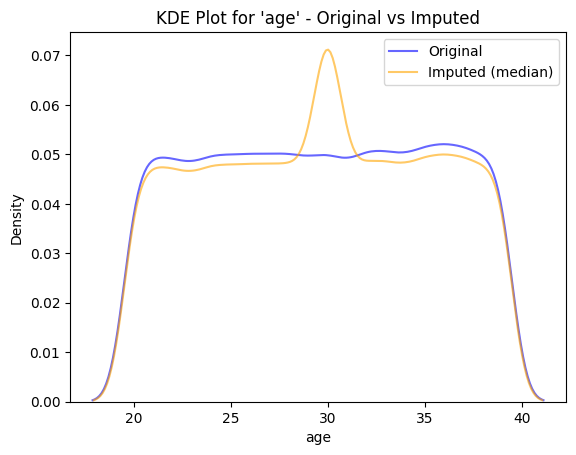

In [21]:

impute_and_plot(x_train,'age','median')

* Use advance KNN imputer in place of median

Missing values in the 'ratings' column: 1510
count    34891.000000
mean         4.635058
std          0.314049
min          2.500000
25%          4.500000
50%          4.700000
75%          4.900000
max          5.000000
Name: ratings, dtype: float64
Imputing 'ratings' with median: 4.7


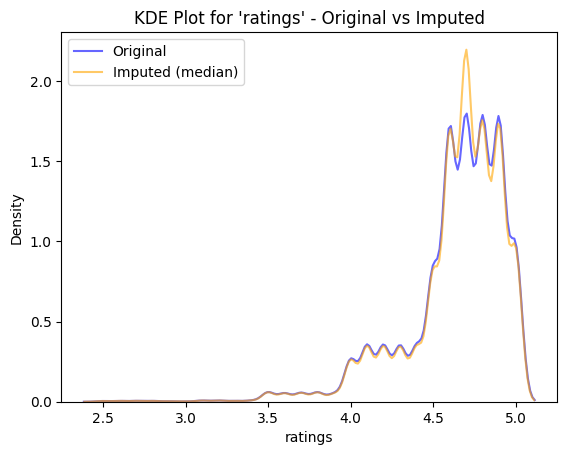

In [22]:
impute_and_plot(x_train,'ratings')

* use advance KNN imputer in place of mean

421

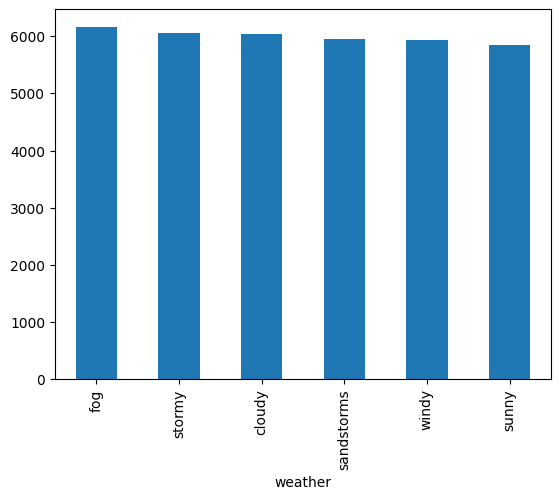

In [23]:
# weather
x_train.weather.value_counts().plot(kind='bar')
x_train.weather.isna().sum()
# sns.countplot(x_train['weather'])

* no dominant category are there. so we use missingindicator 
  

In [24]:
missing_weather=MissingIndicator()

pd.concat([x_train['weather'],missing_weather.fit_transform(x_train[['weather']])],axis=1)

,weather,missingindicator_weather
11029,windy,False
15665,windy,False
14475,stormy,False
29199,windy,False
22514,sandstorms,False
...,...,...
11284,sandstorms,False
44732,cloudy,False
38158,fog,False
860,windy,False


Column: traffic
Missing Values: 407
Value Counts (before filling):
traffic
low       12323
jam       11320
medium     8773
high       3578
Name: count, dtype: int64


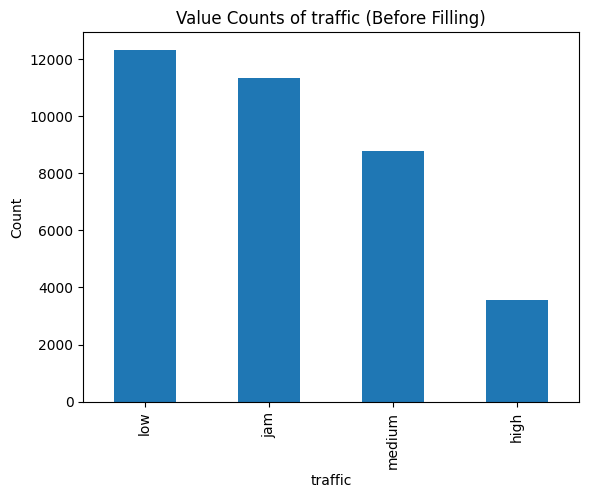

Value Counts (after filling missing values):
traffic
low       12730
jam       11320
medium     8773
high       3578
Name: count, dtype: int64


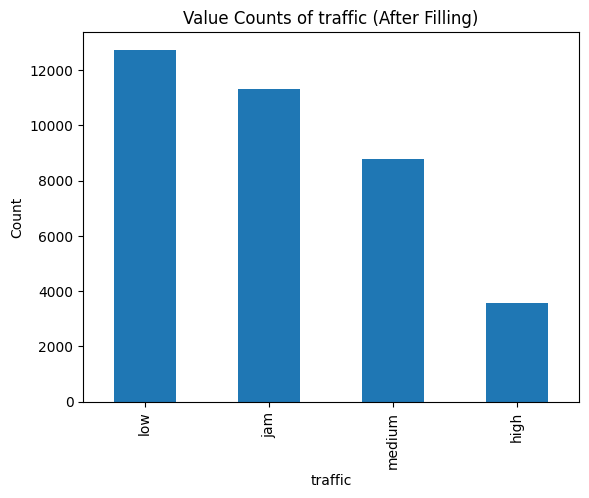

In [25]:
analyze_categorical_column(x_train,'traffic')

Column: festival
Missing Values: 188
Value Counts (before filling):
festival
no     35474
yes      739
Name: count, dtype: int64


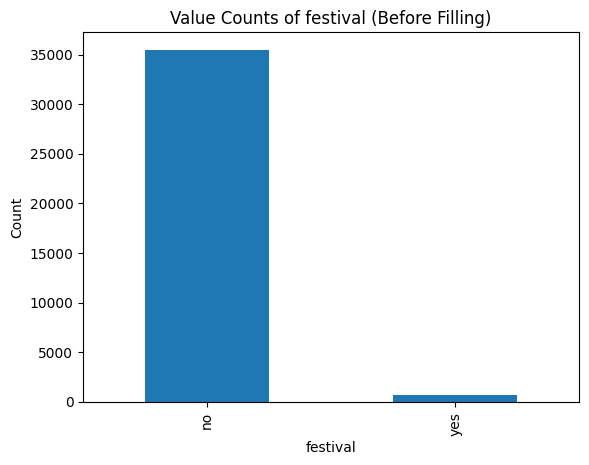

Value Counts (after filling missing values):
festival
no     35662
yes      739
Name: count, dtype: int64


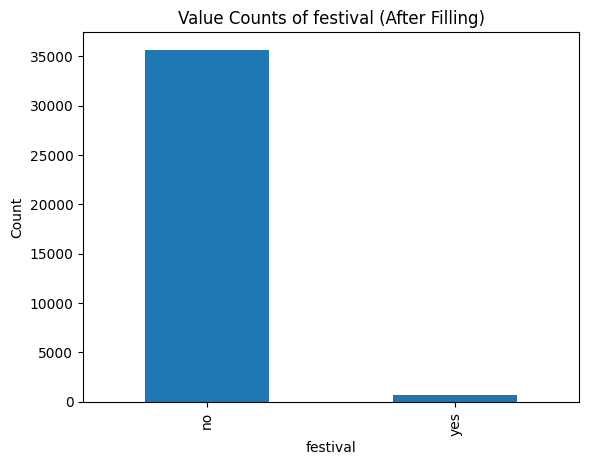

In [26]:
analyze_categorical_column(x_train,'festival')

Column: city_type
Missing Values: 968
Value Counts (before filling):
city_type
metropolitian    27245
urban             8058
semi-urban         130
Name: count, dtype: int64


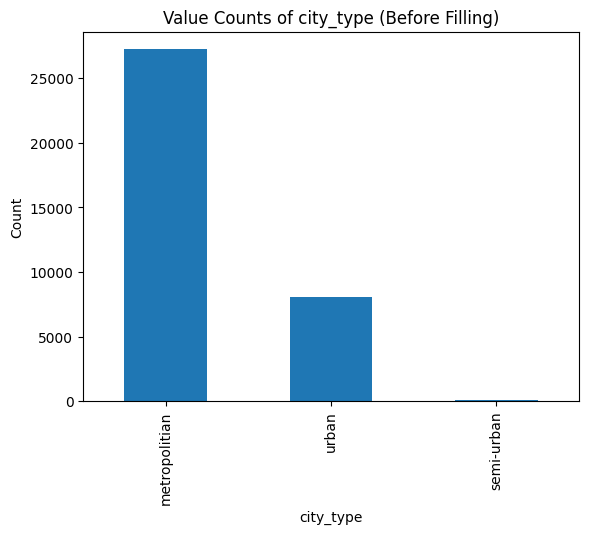

Value Counts (after filling missing values):
city_type
metropolitian    28213
urban             8058
semi-urban         130
Name: count, dtype: int64


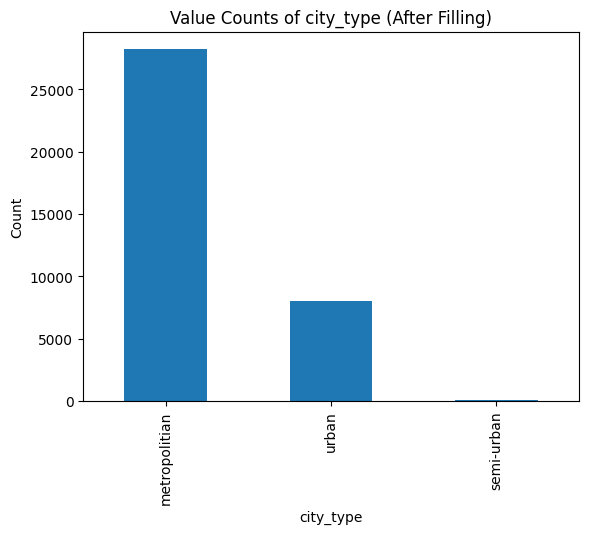

In [27]:
analyze_categorical_column(x_train,'city_type')

Missing values in the 'pickup_time_minutes' column: 1298
count    35103.000000
mean         9.998718
std          4.082279
min          5.000000
25%          5.000000
50%         10.000000
75%         15.000000
max         15.000000
Name: pickup_time_minutes, dtype: float64
Imputing 'pickup_time_minutes' with median: 10.0


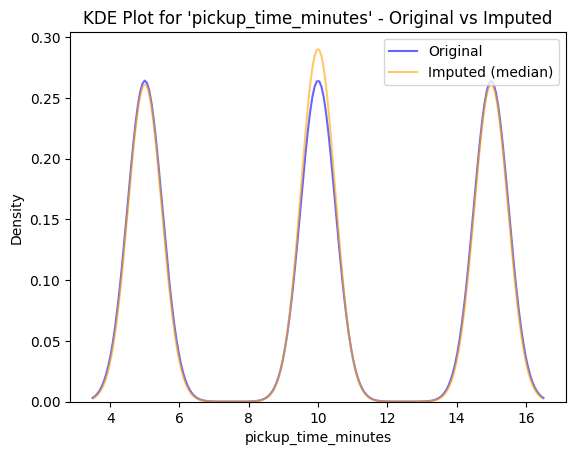

In [28]:
impute_and_plot(x_train,'pickup_time_minutes')

Column: order_time_of_day
Missing Values: 1646
Value Counts (before filling):
order_time_of_day
night        10994
evening      10906
morning       6883
afternoon     5972
Name: count, dtype: int64


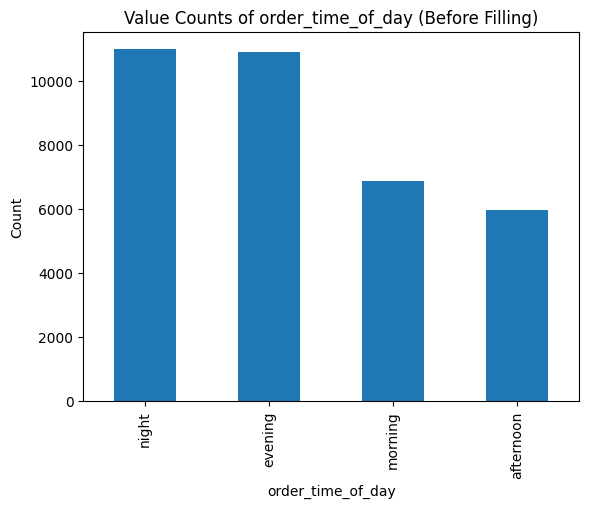

Value Counts (after filling missing values):
order_time_of_day
night        12640
evening      10906
morning       6883
afternoon     5972
Name: count, dtype: int64


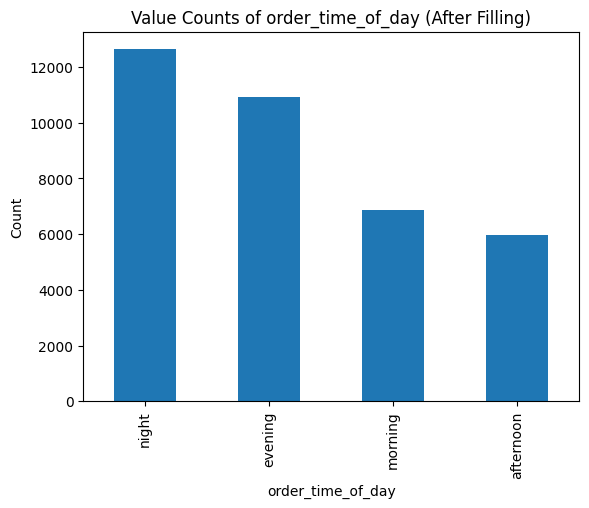

In [29]:
analyze_categorical_column(x_train,'order_time_of_day')

Column: distance_type
Missing Values: 2931
Value Counts (before filling):
distance_type
long         9025
short        8998
medium       8993
very_long    6454
Name: count, dtype: int64


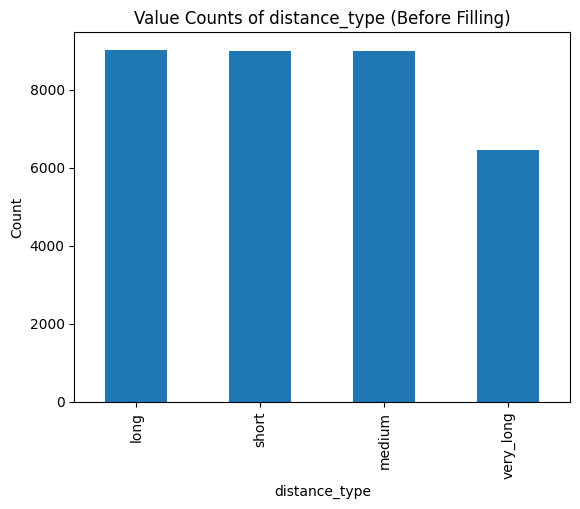

Value Counts (after filling missing values):
distance_type
long         11956
short         8998
medium        8993
very_long     6454
Name: count, dtype: int64


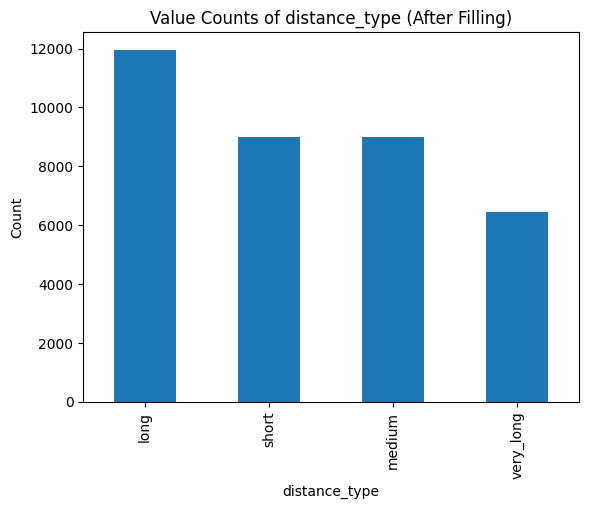

In [30]:
analyze_categorical_column(x_train,'distance_type')

Missing values in the 'distance' column: 2931
count    33470.000000
mean         9.738154
std          5.608401
min          1.465067
25%          4.657672
50%          9.193421
75%         13.681057
max         20.969489
Name: distance, dtype: float64
Imputing 'distance' with median: 9.19342145967692


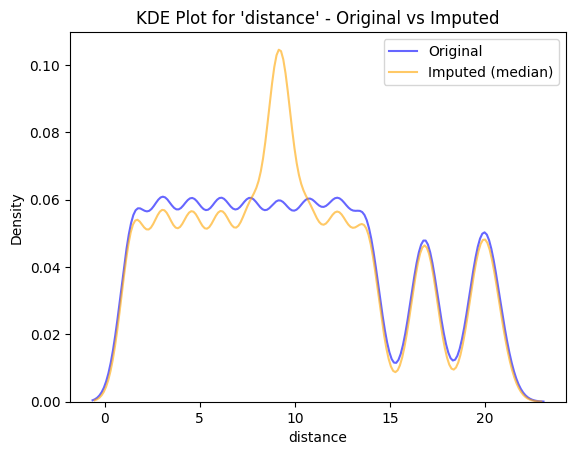

In [31]:
impute_and_plot(x_train,'distance')

# Imputation Pipeline

In [32]:
nominal_cat_cols

['weather',
 'type_of_order',
 'type_of_vehicle',
 'festival',
 'city_type',
 'city_name',
 'order_month',
 'order_day_of_week',
 'is_weekend',
 'order_time_of_day']

In [33]:
x_train[nominal_cat_cols].isnull().sum()

# features to fill values with mode

features_to_fill_mode = ['multiple_deliveries','festival','city_type']
features_to_fill_missing = [col for col in nominal_cat_cols if col not in features_to_fill_mode]

features_to_fill_missing

['weather',
 'type_of_order',
 'type_of_vehicle',
 'city_name',
 'order_month',
 'order_day_of_week',
 'is_weekend',
 'order_time_of_day']

In [34]:
# simple imputer to fill categorical vars with mode

simple_imputer = ColumnTransformer(transformers=[
    ("mode_imputer",SimpleImputer(strategy="most_frequent"),features_to_fill_mode),
    ("missing_imputer",SimpleImputer(strategy="constant",fill_value="missing"),features_to_fill_missing)
],remainder="passthrough",n_jobs=-1,force_int_remainder_cols=False,verbose_feature_names_out=False)

simple_imputer

ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                  remainder='passthrough',
                  transformers=[('mode_imputer',
                                 SimpleImputer(strategy='most_frequent'),
                                 ['multiple_deliveries', 'festival',
                                  'city_type']),
                                ('missing_imputer',
                                 SimpleImputer(fill_value='missing',
                                               strategy='constant'),
                                 ['weather', 'type_of_order', 'type_of_vehicle',
                                  'city_name', 'order_month',
                                  'order_day_of_week', 'is_weekend',
                                  'order_time_of_day'])],
                  verbose_feature_names_out=False)

In [35]:
simple_imputer.fit_transform(x_train).isnull().sum()

multiple_deliveries       0
festival                  0
city_type                 0
weather                   0
type_of_order             0
type_of_vehicle           0
city_name                 0
order_month               0
order_day_of_week         0
is_weekend                0
order_time_of_day         0
age                    1470
ratings                1510
traffic                 407
vehicle_condition         0
pickup_time_minutes    1298
distance               2931
distance_type          2931
dtype: int64

In [36]:
# do basic preprocessing

num_cols = ["age","ratings","pickup_time_minutes","distance"]

nominal_cat_cols = ['weather','type_of_order',
                    'type_of_vehicle',"festival",
                    "city_type","city_name","order_month",
                    "order_day_of_week",
                    "is_weekend",
                    "order_time_of_day"]

ordinal_cat_cols = ["traffic","distance_type"]

# generate order for ordinal encoding

traffic_order = ["low","medium","high","jam"]

distance_type_order = ["short","medium","long","very_long"]

In [37]:
# build a preprocessor

preprocessor = ColumnTransformer(transformers=[
    ("scale", MinMaxScaler(), num_cols),
    ("nominal_encode", OneHotEncoder(drop="first",handle_unknown="ignore",
                                     sparse_output=False), nominal_cat_cols),
    ("ordinal_encode", OrdinalEncoder(categories=[traffic_order,distance_type_order],
                                      encoded_missing_value=-999,
                                      handle_unknown="use_encoded_value",
                                      unknown_value=-1), ordinal_cat_cols)
],remainder="passthrough",n_jobs=-1,force_int_remainder_cols=False,verbose_feature_names_out=False)


preprocessor

ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                  remainder='passthrough',
                  transformers=[('scale', MinMaxScaler(),
                                 ['age', 'ratings', 'pickup_time_minutes',
                                  'distance']),
                                ('nominal_encode',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['weather', 'type_of_order', 'type_of_vehicle',
                                  'festival', 'city_type', 'city_name',
                                  'order_month', 'order_day_of_week',
                                  'is_weekend', 'order_time_of_day']),
                                ('ordinal_encode',
                                 OrdinalEncoder(categories=[['low', 'medium',
                                                             'high', 'jam'],
                                                            ['short', 'medium',
                                                             'long',
                                                             'very_long']],
                                                encoded_missing_value=-999,
                                                handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 ['traffic', 'distance_type'])],
                  verbose_feature_names_out=False)

In [38]:
preprocessor.fit_transform(x_train)

,age,ratings,pickup_time_minutes,distance,weather_fog,weather_sandstorms,weather_stormy,weather_sunny,weather_windy,weather_nan,...,order_day_of_week_wednesday,is_weekend_1,order_time_of_day_evening,order_time_of_day_morning,order_time_of_day_night,order_time_of_day_nan,traffic,distance_type,vehicle_condition,multiple_deliveries
11029,0.315789,0.88,0.5,0.395429,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,3.0,1.0,2,1.0
15665,0.052632,0.96,0.0,0.236688,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2,1.0
14475,NaN,NaN,NaN,0.004588,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2,1.0
29199,0.631579,0.88,1.0,0.993990,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0,0,1.0
22514,0.736842,0.96,0.0,0.389195,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,0.473684,0.88,0.0,0.563939,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,3.0,2.0,2,0.0
44732,0.842105,0.92,0.5,0.002839,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0
38158,0.842105,0.76,0.5,NaN,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,3.0,-1.0,1,0.0
860,0.263158,0.96,0.0,0.322792,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,2,1.0


In [39]:
# knn imputer

knn_imputer = KNNImputer(n_neighbors=5)

# build the pipeline

processing_pipeline = Pipeline(steps=[
                                ("simple_imputer",simple_imputer),
                                ("preprocess",preprocessor),
                                ("knn_imputer",knn_imputer)
                            ])

processing_pipeline

Pipeline(steps=[('simple_imputer',
                 ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                                   remainder='passthrough',
                                   transformers=[('mode_imputer',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['multiple_deliveries',
                                                   'festival', 'city_type']),
                                                 ('missing_imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant'),
                                                  ['weather', 'type_of_order',
                                                   'type_of_vehi...
                                                   'city_name', 'order_month',
                                                   'order_day_of_week',
                                                   'is_weekend',
                                                   'order_time_of_day']),
                                                 ('ordinal_encode',
                                                  OrdinalEncoder(categories=[['low',
                                                                              'medium',
                                                                              'high',
                                                                              'jam'],
                                                                             ['short',
                                                                              'medium',
                                                                              'long',
                                                                              'very_long']],
                                                                 encoded_missing_value=-999,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['traffic',
                                                   'distance_type'])],
                                   verbose_feature_names_out=False)),
                ('knn_imputer', KNNImputer())])

In [40]:
# fit and transform the pipeline on X_train

processing_pipeline.fit_transform(x_train)

,age,ratings,pickup_time_minutes,distance,weather_fog,weather_missing,weather_sandstorms,weather_stormy,weather_sunny,weather_windy,...,order_day_of_week_wednesday,is_weekend_1,order_time_of_day_evening,order_time_of_day_missing,order_time_of_day_morning,order_time_of_day_night,traffic,distance_type,multiple_deliveries,vehicle_condition
11029,0.315789,0.880,0.5,0.395429,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,3.0,1.0,1.0,2.0
15665,0.052632,0.960,0.0,0.236688,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0
14475,0.536842,0.896,0.5,0.004588,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0
29199,0.631579,0.880,1.0,0.993990,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0,1.0,0.0
22514,0.736842,0.960,0.0,0.389195,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,0.473684,0.880,0.0,0.563939,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,3.0,2.0,0.0,2.0
44732,0.842105,0.920,0.5,0.002839,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
38158,0.842105,0.760,0.5,0.189351,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,3.0,-1.0,0.0,1.0
860,0.263158,0.960,0.0,0.322792,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0


In [48]:
model_pipe = Pipeline(steps=[
                                ("preprocessing",processing_pipeline),
                                ("model",rf)
                            ])

model_pipe

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('simple_imputer',
                                  ColumnTransformer(force_int_remainder_cols=False,
                                                    n_jobs=-1,
                                                    remainder='passthrough',
                                                    transformers=[('mode_imputer',
                                                                   SimpleImputer(strategy='most_frequent'),
                                                                   ['multiple_deliveries',
                                                                    'festival',
                                                                    'city_type']),
                                                                  ('missing_imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant'),
                                                                   ['weath...
                                                                  ('ordinal_encode',
                                                                   OrdinalEncoder(categories=[['low',
                                                                                               'medium',
                                                                                               'high',
                                                                                               'jam'],
                                                                                              ['short',
                                                                                               'medium',
                                                                                               'long',
                                                                                               'very_long']],
                                                                                  encoded_missing_value=-999,
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1),
                                                                   ['traffic',
                                                                    'distance_type'])],
                                                    verbose_feature_names_out=False)),
                                 ('knn_imputer', KNNImputer())])),
                ('model', RandomForestRegressor(n_jobs=-1, random_state=42))])

In [50]:
# fit the pipeline on data

model_pipe.fit(x_train,y_train_pt.values.ravel())

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('simple_imputer',
                                  ColumnTransformer(force_int_remainder_cols=False,
                                                    n_jobs=-1,
                                                    remainder='passthrough',
                                                    transformers=[('mode_imputer',
                                                                   SimpleImputer(strategy='most_frequent'),
                                                                   ['multiple_deliveries',
                                                                    'festival',
                                                                    'city_type']),
                                                                  ('missing_imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant'),
                                                                   ['weath...
                                                                  ('ordinal_encode',
                                                                   OrdinalEncoder(categories=[['low',
                                                                                               'medium',
                                                                                               'high',
                                                                                               'jam'],
                                                                                              ['short',
                                                                                               'medium',
                                                                                               'long',
                                                                                               'very_long']],
                                                                                  encoded_missing_value=-999,
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1),
                                                                   ['traffic',
                                                                    'distance_type'])],
                                                    verbose_feature_names_out=False)),
                                 ('knn_imputer', KNNImputer())])),
                ('model', RandomForestRegressor(n_jobs=-1, random_state=42))])

In [43]:
# fit the pipeline on data

model_pipe.fit(x_train,y_train_pt)

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('simple_imputer',
                                  ColumnTransformer(force_int_remainder_cols=False,
                                                    n_jobs=-1,
                                                    remainder='passthrough',
                                                    transformers=[('mode_imputer',
                                                                   SimpleImputer(strategy='most_frequent'),
                                                                   ['multiple_deliveries',
                                                                    'festival',
                                                                    'city_type']),
                                                                  ('missing_imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant'),
                                                                   ['weath...
                                                                    'is_weekend',
                                                                    'order_time_of_day']),
                                                                  ('ordinal_encode',
                                                                   OrdinalEncoder(categories=[['low',
                                                                                               'medium',
                                                                                               'high',
                                                                                               'jam'],
                                                                                              ['short',
                                                                                               'medium',
                                                                                               'long',
                                                                                               'very_long']],
                                                                                  encoded_missing_value=-999,
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1),
                                                                   ['traffic',
                                                                    'distance_type'])],
                                                    verbose_feature_names_out=False)),
                                 ('knn_imputer', KNNImputer())])),
                ('model', LinearRegression())])

In [51]:
# get the predictions
y_pred_train = model_pipe.predict(x_train)
y_pred_test = model_pipe.predict(x_test)


# get the actual predictions values

y_pred_train_org = pt.inverse_transform(y_pred_train.reshape(-1,1))
y_pred_test_org = pt.inverse_transform(y_pred_test.reshape(-1,1))


print(f"The train error is {mean_absolute_error(y_train,y_pred_train_org):.2f} minutes")
print(f"The test error is {mean_absolute_error(y_test,y_pred_test_org):.2f} minutes")



print(f"The train r2 score is {r2_score(y_train,y_pred_train_org):.2f}")
print(f"The test r2 score is {r2_score(y_test,y_pred_test_org):.2f}")


The train error is 1.22 minutes
The test error is 3.29 minutes
The train r2 score is 0.97
The test r2 score is 0.80


In [45]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42,n_jobs=-1)

model_pipe = Pipeline(steps=[
                                ("preprocessing",processing_pipeline),
                                ("model",rf)
                            ])

model_pipe

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('simple_imputer',
                                  ColumnTransformer(force_int_remainder_cols=False,
                                                    n_jobs=-1,
                                                    remainder='passthrough',
                                                    transformers=[('mode_imputer',
                                                                   SimpleImputer(strategy='most_frequent'),
                                                                   ['multiple_deliveries',
                                                                    'festival',
                                                                    'city_type']),
                                                                  ('missing_imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant'),
                                                                   ['weath...
                                                                  ('ordinal_encode',
                                                                   OrdinalEncoder(categories=[['low',
                                                                                               'medium',
                                                                                               'high',
                                                                                               'jam'],
                                                                                              ['short',
                                                                                               'medium',
                                                                                               'long',
                                                                                               'very_long']],
                                                                                  encoded_missing_value=-999,
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1),
                                                                   ['traffic',
                                                                    'distance_type'])],
                                                    verbose_feature_names_out=False)),
                                 ('knn_imputer', KNNImputer())])),
                ('model', RandomForestRegressor(n_jobs=-1, random_state=42))])

In [46]:
# fit the pipeline on data

model_pipe.fit(x_train,y_train_pt.values.ravel())

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('simple_imputer',
                                  ColumnTransformer(force_int_remainder_cols=False,
                                                    n_jobs=-1,
                                                    remainder='passthrough',
                                                    transformers=[('mode_imputer',
                                                                   SimpleImputer(strategy='most_frequent'),
                                                                   ['multiple_deliveries',
                                                                    'festival',
                                                                    'city_type']),
                                                                  ('missing_imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant'),
                                                                   ['weath...
                                                                  ('ordinal_encode',
                                                                   OrdinalEncoder(categories=[['low',
                                                                                               'medium',
                                                                                               'high',
                                                                                               'jam'],
                                                                                              ['short',
                                                                                               'medium',
                                                                                               'long',
                                                                                               'very_long']],
                                                                                  encoded_missing_value=-999,
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1),
                                                                   ['traffic',
                                                                    'distance_type'])],
                                                    verbose_feature_names_out=False)),
                                 ('knn_imputer', KNNImputer())])),
                ('model', RandomForestRegressor(n_jobs=-1, random_state=42))])

In [47]:
# get the predictions
y_pred_train = model_pipe.predict(x_train)
y_pred_test = model_pipe.predict(x_test) 

# get the actual predictions values

y_pred_train_org = pt.inverse_transform(y_pred_train.reshape(-1,1))
y_pred_test_org = pt.inverse_transform(y_pred_test.reshape(-1,1))

print(f"The train error is {mean_absolute_error(y_train,y_pred_train_org):.2f} minutes")
print(f"The test error is {mean_absolute_error(y_test,y_pred_test_org):.2f} minutes")

print(f"The train r2 score is {r2_score(y_train,y_pred_train_org):.2f}")
print(f"The test r2 score is {r2_score(y_test,y_pred_test_org):.2f}")



The train error is 1.22 minutes
The test error is 3.29 minutes
The train r2 score is 0.97
The test r2 score is 0.80


In [52]:
# calculate the cross val score

from sklearn.model_selection import cross_val_score

scores = cross_val_score(model_pipe,x_train,y_train_pt.values.ravel(),cv=5,scoring="r2",n_jobs=-1)

scores

array([0.77573895, 0.78339997, 0.78179655, 0.77753405, 0.77929085])

In [53]:
scores.mean()

0.7795520750147311

In [54]:
# log experiment

with mlflow.start_run(run_name="Impute Missing Values"):
    # mlflow log experiment type
    mlflow.log_param("experiment_type","Impute Missing Values")
    # log model params
    mlflow.log_params(rf.get_params())

    # log metrics
    mlflow.log_metric("training_error",mean_absolute_error(y_train,y_pred_train_org))
    mlflow.log_metric("test_error",mean_absolute_error(y_test,y_pred_test_org))
    mlflow.log_metric("training_r2",r2_score(y_train,y_pred_train_org))
    mlflow.log_metric("test_r2",r2_score(y_test,y_pred_test_org))
    mlflow.log_metric("cross_val",scores.mean())

NameError: name 'mlflow' is not defined